In [136]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer

from xgboost import XGBClassifier

In [2]:
sns.set_theme(style="whitegrid")

# Titanic - Machine Learning from Disaster
### Kaggle Competitions

## Dataset and EDA

In [3]:
# Read the train dataset
titanic_data = pd.read_csv("/kaggle/input/titanic/train.csv", index_col = "PassengerId")
titanic_data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


In [4]:
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [5]:
# Describe numerical features
titanic_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [6]:
# Separate features and target
titanic = titanic_data.drop(columns = "Survived")
survived = titanic_data.Survived

titanic.shape, survived.shape

((891, 10), (891,))

In [7]:
# Select numerical columns (float only)
numerical_column_selector = make_column_selector(dtype_include = "float64")
float_cols = numerical_column_selector(titanic)

float_cols

['Age', 'Fare']

In [263]:
# Select nominal categorical features
categorical_column_selector = make_column_selector(dtype_include = "object")
object_cols = categorical_column_selector(titanic)


# Number of unique entries in each column with categorical data
categorical_nunique = titanic[object_cols].nunique()
categorical_nunique

Name        891
Sex           2
Ticket      681
Cabin       147
Embarked      3
dtype: int64

In [9]:
# Select ordinal categorical features
ordinal_column_selector = make_column_selector(dtype_include = "int64")
int_cols = ordinal_column_selector(titanic)


# Number of unique entries in each column with ordinal data
ordinal_nunique = titanic[int_cols].nunique()
ordinal_nunique

Pclass    3
SibSp     7
Parch     7
dtype: int64

In [10]:
# Select low cardinality categorical features
categorical_low_cardinality = categorical_nunique[categorical_nunique < 5].index.tolist()
categorical_low_cardinality

['Sex', 'Embarked']

In [11]:
# Read the test dataset
titanic_test = pd.read_csv("/kaggle/input/titanic/test.csv", index_col = "PassengerId")
titanic_test

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...
1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S


In [12]:
titanic_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


`Age`, `Cabin` and `Embarked` have values in both train and test set; `Fare` has missing values in test set only

##### `Survived`

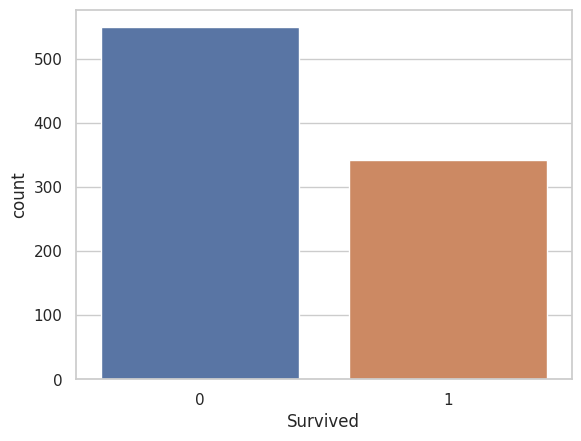

In [13]:
sns.countplot(data = titanic_data, x = "Survived")
plt.show()

##### `Pclass`

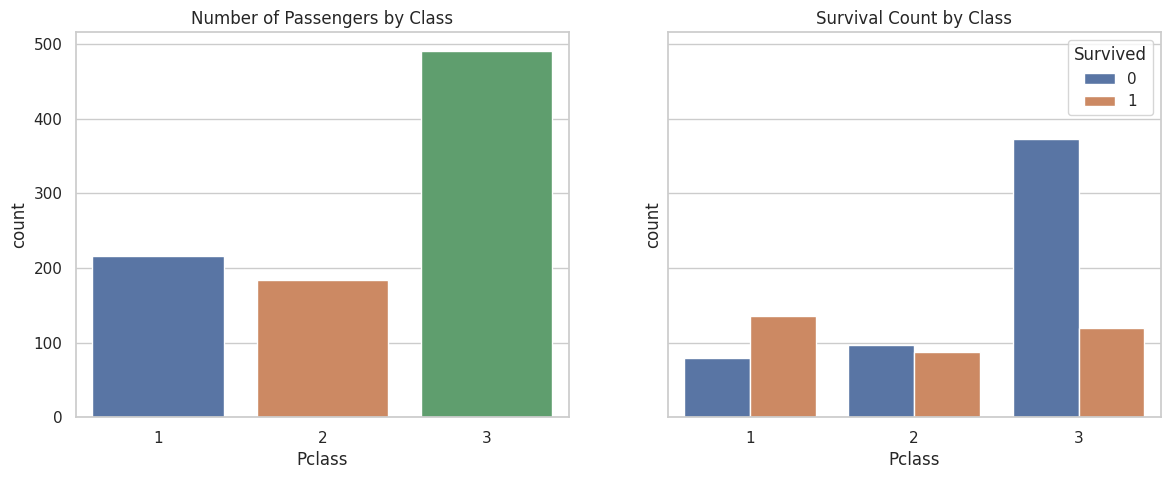

In [14]:
fig, axes = plt.subplots(1, 2, figsize = (14, 5), sharey = True)

sns.countplot(data = titanic_data, x = "Pclass", ax = axes[0]).set(title='Number of Passengers by Class')
sns.countplot(data = titanic_data, x = "Pclass", hue = "Survived", ax = axes[1]).set(title='Survival Count by Class')

plt.show()

`Sex`

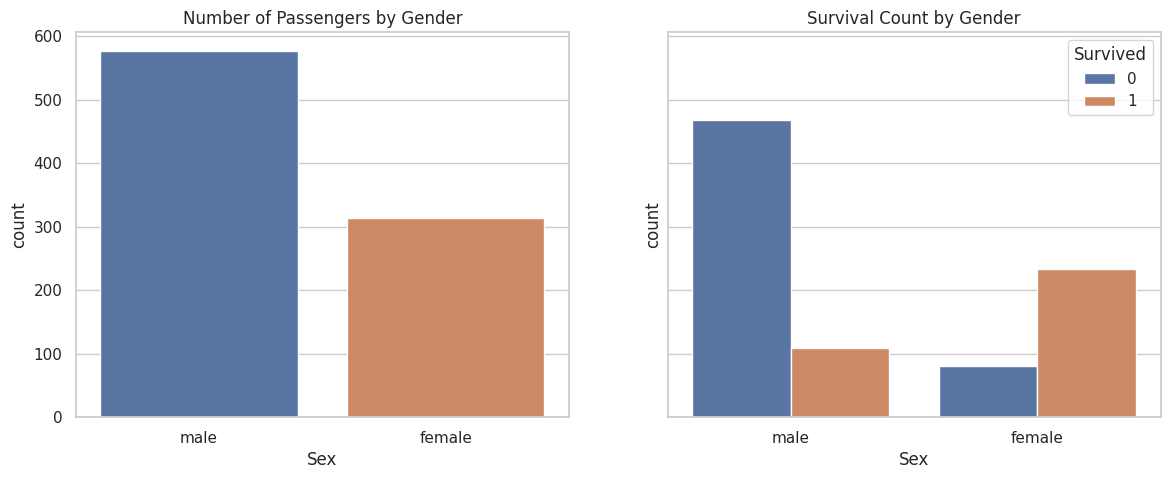

In [15]:
fig, axes = plt.subplots(1, 2, figsize = (14, 5), sharey = True)

sns.countplot(data = titanic_data, x = "Sex", ax = axes[0]).set(title='Number of Passengers by Gender')
sns.countplot(data = titanic_data, x = "Sex", hue = "Survived", ax = axes[1]).set(title='Survival Count by Gender')

plt.show()


`Age`

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


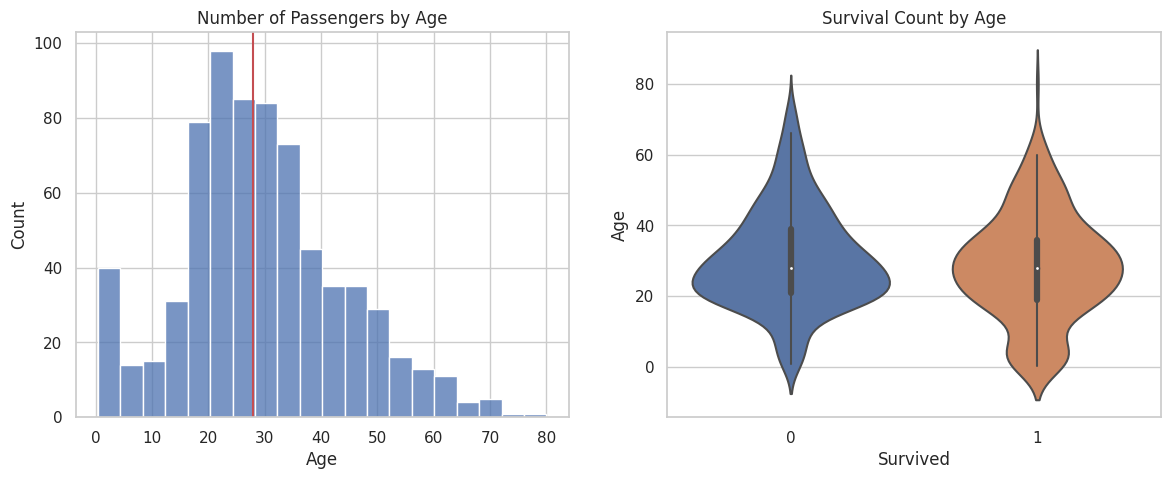

In [16]:
fig, axes = plt.subplots(1, 2, figsize = (14, 5), sharey = False)

sns.histplot(data = titanic_data, x = "Age", ax = axes[0]).set(title='Number of Passengers by Age')
axes[0].axvline(titanic_data.Age.median(), c = "r")
sns.violinplot(data = titanic_data, x = "Survived", y = "Age", ax = axes[1]).set(title='Survival Count by Age')

plt.show()


`Cabin`

In [17]:
titanic_data.Cabin.unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [18]:
titanic_data.Cabin.value_counts().head(10)

Cabin
B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
F2             3
E101           3
D              3
C78            2
C93            2
Name: count, dtype: int64

In [19]:
titanic_data[titanic_data.Cabin.isin(titanic_data.Cabin.value_counts().head(3).index)].sort_values("Cabin")

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
391,1,1,"Carter, Mr. William Ernest",male,36.0,1,2,113760,120.0000,B96 B98,S
436,1,1,"Carter, Miss. Lucile Polk",female,14.0,1,2,113760,120.0000,B96 B98,S
764,1,1,"Carter, Mrs. William Ernest (Lucile Polk)",female,36.0,1,2,113760,120.0000,B96 B98,S
803,1,1,"Carter, Master. William Thornton II",male,11.0,1,2,113760,120.0000,B96 B98,S
28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0000,C23 C25 C27,S
89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.0000,C23 C25 C27,S
342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.0000,C23 C25 C27,S
439,0,1,"Fortune, Mr. Mark",male,64.0,1,4,19950,263.0000,C23 C25 C27,S
11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S


`Name`

In [20]:
titanic_data[titanic_data.Name.str.contains("Carter")]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
250,0,2,"Carter, Rev. Ernest Courtenay",male,54.0,1,0,244252,26.0,NaN,S
391,1,1,"Carter, Mr. William Ernest",male,36.0,1,2,113760,120.0,B96 B98,S
436,1,1,"Carter, Miss. Lucile Polk",female,14.0,1,2,113760,120.0,B96 B98,S
764,1,1,"Carter, Mrs. William Ernest (Lucile Polk)",female,36.0,1,2,113760,120.0,B96 B98,S
803,1,1,"Carter, Master. William Thornton II",male,11.0,1,2,113760,120.0,B96 B98,S
855,0,2,"Carter, Mrs. Ernest Courtenay (Lilian Hughes)",female,44.0,1,0,244252,26.0,NaN,S


At first we used a count vectorizer on the `Name` column, hoping to to extract information such as family ralations (same last name) and titles (Mr., Mrs.,Miss etc.). Names that do not repeat, like given names, and titles  that occur only once are of no use for the model, so we set `min_df = 2`, which is to say that words with strictly less than 2 occurences are excluded from the vocabulary and go to the stop words set. This this approach created false relation between persons with the same first names, common names like William (64 occurences), Jhon (44 occurences) and Mary (20 occurences) lead to model with poor performance. To counteract this problem, we manualy extract surnames and titles only.

In [21]:
titanic_data_name = titanic_data.Name.str.split(",", expand = True)
titanic_data_name.columns = ["Surname", "Rest"]
titanic_data_name[["Title", "Rest"]] = titanic_data_name.Rest.str.split(".", expand = True, n = 1)

titanic_data_name

,Surname,Rest,Title
PassengerId,,,
1,Braund,Owen Harris,Mr
2,Cumings,John Bradley (Florence Briggs Thayer),Mrs
3,Heikkinen,Laina,Miss
4,Futrelle,Jacques Heath (Lily May Peel),Mrs
5,Allen,William Henry,Mr
...,...,...,...
887,Montvila,Juozas,Rev
888,Graham,Margaret Edith,Miss
889,Johnston,"Catherine Helen ""Carrie""",Miss


In [164]:
title_count_vectorizer = CountVectorizer(min_df = 3)
title_vectorized = title_count_vectorizer.fit_transform(titanic_data_name.Title)

In [165]:
len(title_count_vectorizer.vocabulary_)

6

In [166]:
len(title_count_vectorizer.stop_words_)

12

In [171]:
title_document_frequency = pd.DataFrame(
    title_vectorized.toarray(), 
    columns = title_count_vectorizer.get_feature_names_out()
).sum().sort_values(ascending = False)

title_document_frequency

mr        517
miss      182
mrs       125
master     40
dr          7
rev         6
dtype: int64

In [173]:
pca_title = PCA()
pca_title.fit(title_vectorized.toarray())

PCA()

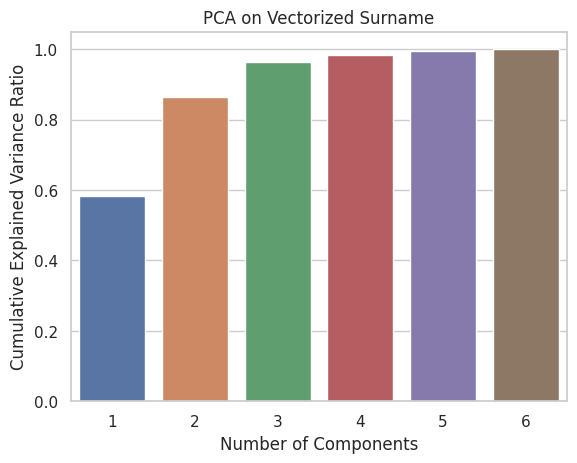

In [207]:
sns.barplot(x = np.arange(1, pca_title.n_components_ + 1), y = np.cumsum(pca_title.explained_variance_ratio_))


plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title("PCA on Vectorized Surname")

plt.show()

In [168]:
name_count_vectorizer = CountVectorizer(min_df = 2)
name_vectorized = name_count_vectorizer.fit_transform(titanic_data_name.Surname)

In [169]:
len(name_count_vectorizer.vocabulary_)

143

In [147]:
len(name_count_vectorizer.stop_words_)

542

In [148]:
name_document_frequency = pd.DataFrame(
    name_vectorized.toarray(), 
    columns = name_count_vectorizer.get_feature_names_out()
).sum().sort_values(ascending = False)

name_document_frequency.head(20)

andersson     9
sage          7
goodwin       6
carter        6
skoog         6
panula        6
johnson       6
van           6
williams      5
rice          5
jensen        4
harper        4
harris        4
hart          4
brown         4
gustafsson    4
palsson       4
smith         4
vander        4
baclini       4
dtype: int64

In [28]:
name_document_frequency.tail(20)

kantor         2
johnston       2
jacobsohn      2
abelson        2
holverson      2
hocking        2
hippach        2
herman         2
hays           2
hamalainen     2
hakkarainen    2
hagland        2
gordon         2
goldenberg     2
futrelle       2
frolicher      2
frauenthal     2
franchi        2
duff           2
zabour         2
dtype: int64

In [208]:
svd = TruncatedSVD(140)

In [209]:
svd.fit(name_vectorized)

TruncatedSVD(n_components=140)

In [210]:
svd.n_components

140

In [211]:
svd.explained_variance_ratio_.sum()

0.9999999999999997

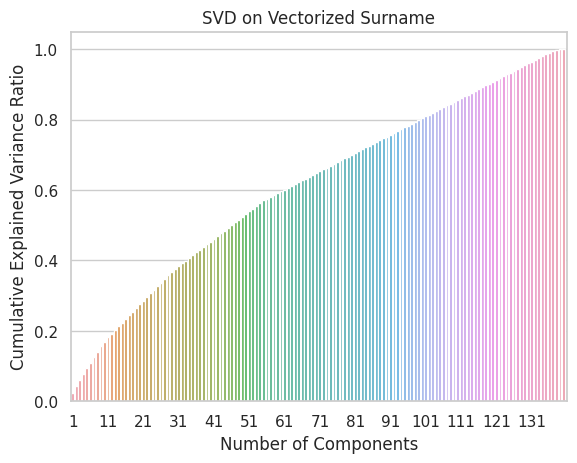

In [217]:
sns.barplot(x = np.arange(1, svd.n_components + 1), y = np.cumsum(svd.explained_variance_ratio_))

plt.xticks(np.arange(0, svd.n_components + 1, step=10))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title("SVD on Vectorized Surname")

plt.show()

## Preprocessing

In [213]:
# Split the data into train and validation sets
titanic_train, titanic_val, survived_train, survived_val = train_test_split(
    titanic, 
    survived, 
    test_size = 0.3,
    random_state = 42
)


(titanic_train.shape, survived_val.shape), (titanic_val.shape, survived_val.shape)

(((623, 10), (268,)), ((268, 10), (268,)))

In [295]:
def extract_surname(name):
    assert name.name == "Name", "Surname cannot be extracted, source column must be 'Name'"
  
    return name.str.split(",", expand = True)[0]


def surname_feature_names_out(self, input_features):
    return ["Surname"]


def extract_title(name):
    assert name.name == "Name", "Title cannot be extracted, source column must be 'Name'"
    
    # Regex matches the characters between the first comma and space, and first dot
    return name.str.extract(r'(?<=,\s)([^.]+)') 


def title_feature_names_out(self, input_features):
    return ["Title"]

    

In [304]:
ft = FunctionTransformer(extract_title)
ft.fit_transform(titanic_data.Name).value_counts()

0           
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Major             2
Col               2
Mlle              2
Sir               1
Ms                1
Capt              1
Mme               1
Lady              1
Jonkheer          1
Don               1
the Countess      1
Name: count, dtype: int64

In [305]:
# Preprocessing for numerical data
numerical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = "median")),
    ('scaler', MinMaxScaler())
])

# Preprocessing for nominal categorical data
nominal_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = "most_frequent")),
    ('onehot', OneHotEncoder(drop = "if_binary", handle_unknown='ignore'))
])

# Preprocessing for ordinal categorical data
ordinal_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = "most_frequent")),
    ('onehot', OneHotEncoder(drop = None, handle_unknown='ignore'))
])

# Preprocessing for surname (from "Name" feature)
surname_transformer = Pipeline(steps = [
    ("extract_surname", FunctionTransformer(extract_surname, feature_names_out = surname_feature_names_out)),
    ("vectorizer", CountVectorizer(min_df = 2)),
    ("svd", TruncatedSVD(n_components = 100))
])

# Preprocessing for title (from "Name" feature)
title_transformer = Pipeline(steps = [
    ("extract_surname", FunctionTransformer(extract_title, feature_names_out = title_feature_names_out)),
    ("vectorizer", CountVectorizer(min_df = 5)),
    ("svd", TruncatedSVD(n_components = 3))
])


# Join preprocessing for all types of data
preprocessor = ColumnTransformer(
    transformers = [
        ('numerical', numerical_transformer, float_cols),
        ('nominal', nominal_transformer, categorical_low_cardinality),
        ('ordinal', ordinal_transformer, int_cols),
        ("name_surname", surname_transformer, "Name"),
        ("name_title", title_transformer, "Name"), # error in title transformer
        
    ])

## Model

In [306]:
# Define a model 
xgb = XGBClassifier(
#     early_stopping_rounds = 10, 
    random_state = 42
)

# Define grid search with cross-validation
xgb_grid = GridSearchCV(
    estimator = xgb,
    param_grid = {
        "n_estimators": [100],
        "learning_rate": [0.1]
    },
    cv = 8,
    scoring = "accuracy",
    return_train_score = True
)

In [307]:
# Fit the preprocessor, so that it could be used for the `eval_set`
preprocessor.fit(titanic)

AttributeError: 'int' object has no attribute 'lower'

In [303]:
# Transform data
titanic_full_preprocessed = preprocessor.transform(titanic)
titanic_train_preprocessed = preprocessor.transform(titanic_train)
titanic_val_preprocessed = preprocessor.transform(titanic_val)
titanic_test_preprocessed = preprocessor.transform(titanic_test)


 Warnings are expected - reason is the `drop` argument in OHE

In [293]:
titanic_full_preprocessed.shape

(891, 223)

In [294]:
preprocessor.get_feature_names_out()

AttributeError: 'ColumnTransformer' object has no attribute 'transformers_'

In [283]:
xgb_grid.fit(
    titanic_full_preprocessed,
    survived, 
#     eval_set=[(titanic_val_preprocessed, survived_val)], 
#     verbose = False
)

GridSearchCV(cv=8,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.1], 'n_estimators': [100]},
             return_train_score=True, scoring='accuracy')

In [284]:
# # Train the model 
# xgb.fit(
#     titanic_train_preprocessed,
#     survived_train, 
#     eval_set=[(titanic_val_preprocessed, survived_val)], 
#     verbose = False
# )

In [285]:
pd.DataFrame(xgb_grid.cv_results_)[["params", "mean_train_score", "mean_test_score", "rank_test_score"]]

,params,mean_train_score,mean_test_score,rank_test_score
0,"{'learning_rate': 0.1, 'n_estimators': 100}",0.941159,0.837335,1


In [286]:
best_model = xgb_grid.best_estimator_
best_model.score(titanic_train_preprocessed, survived_train)

0.9373996789727127

In [287]:
best_model.score(titanic_full_preprocessed, survived)

0.941638608305275

0.987

##### Base scores

In [288]:
# Score for a model that predicts survival based on gender, female = survived
titanic_is_female = titanic_train.Sex.apply(lambda x: x == "female")
accuracy_score(survived_train, titanic_is_female)

0.7849117174959872

In [229]:
# Score for a model that predicts survival based on class, first class = survived
titanic_is_female = titanic_train.Pclass.apply(lambda x: x == "1")
accuracy_score(survived_train, titanic_is_female)

0.6292134831460674

## Submission

In [230]:
predictions = best_model.predict(titanic_test_preprocessed)

In [231]:
submission = pd.Series(predictions, index = titanic_test.index, name = "Survived")
submission

PassengerId
892     0
893     0
894     0
895     0
896     0
       ..
1305    0
1306    1
1307    0
1308    0
1309    0
Name: Survived, Length: 418, dtype: int64

In [232]:
submission.to_csv("submission.csv")

In [239]:
submission.sum(), len(submission)

(149, 418)

In [236]:
# pd.read_csv("/kaggle/input/titanic/gender_submission.csv")

In [235]:
# pd.read_csv("submission.csv")